# Correlation Matrices

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import os
import warnings
warnings.filterwarnings('ignore')
os.environ["PYTHONWARNINGS"] = "ignore"

In [3]:
cur_folder_name = os.getcwd().split('/')[-1]
if cur_folder_name != "data-cleaning-stability":
    os.chdir("../../../")

print('Current location: ', os.getcwd())

Current location:  /Users/denys_herasymuk/Research/NYU/ML_Lifecycle_Project/Code/data-cleaning-stability


In [4]:
import pandas as pd
from configs.constants import (ACS_INCOME_DATASET, ACS_EMPLOYMENT_DATASET, LAW_SCHOOL_DATASET, GERMAN_CREDIT_DATASET,
                               CARDIOVASCULAR_DISEASE_DATASET, BANK_MARKETING_DATASET, DIABETES_DATASET)
from source.visualizations.correlations_viz import get_data_for_correlation_plots
from notebooks.EDA.EDA_utils import get_correlation_matrix_by_target_names

## Define global configs

In [5]:
from source.custom_classes.database_client import DatabaseClient, get_secrets_path

db_client_1 = DatabaseClient()
db_client_3 = DatabaseClient(secrets_path=get_secrets_path('secrets_3.env'))
db_client_1.connect()
db_client_3.connect()

In [6]:
METRIC_NAMES = ['F1', 'Label_Stability', 'Std', 'Aleatoric_Uncertainty', 'Equalized_Odds_TPR', 'Disparate_Impact', 'Equalized_Odds_TNR',  'Label_Stability_Ratio', 'Std_Ratio', 'Aleatoric_Uncertainty_Ratio']

DATASETS_ALL_SENSITIVE_ATTRS = {
    ACS_INCOME_DATASET: ['SEX', 'RAC1P', 'SEX&RAC1P'],
    LAW_SCHOOL_DATASET: ['male', 'race', 'male&race'],
    GERMAN_CREDIT_DATASET: ['sex', 'age', 'sex&age'],
    CARDIOVASCULAR_DISEASE_DATASET: ['gender'],
    BANK_MARKETING_DATASET: ['age'],
    DIABETES_DATASET: ['Gender'],
    ACS_EMPLOYMENT_DATASET: ['SEX', 'RAC1P', 'SEX&RAC1P'],
}

DATASETS_SENSITIVE_ATTRS = {
    ACS_INCOME_DATASET: 'SEX&RAC1P',
    LAW_SCHOOL_DATASET: 'male&race',
    GERMAN_CREDIT_DATASET: 'sex',
    CARDIOVASCULAR_DISEASE_DATASET: 'gender',
    BANK_MARKETING_DATASET: 'age',
    DIABETES_DATASET: 'Gender',
    ACS_EMPLOYMENT_DATASET: 'SEX&RAC1P',
}

## Read a dataframe with all metrics

In [7]:
metrics_df = get_data_for_correlation_plots(db_client_1=db_client_1,
                                            db_client_3=db_client_3,
                                            dataset_names=[ACS_INCOME_DATASET, ACS_EMPLOYMENT_DATASET, LAW_SCHOOL_DATASET, GERMAN_CREDIT_DATASET,
                               CARDIOVASCULAR_DISEASE_DATASET, BANK_MARKETING_DATASET, DIABETES_DATASET],
                                            missingness_types=['single_mechanism', 'multi_mechanism', 'missingness_shift'],
                                            metric_names=METRIC_NAMES,
                                            dataset_to_group=DATASETS_SENSITIVE_ATTRS)
metrics_df.shape

Extracted data for folk
Extracted data for folk_emp
Extracted data for law_school
Extracted data for german
Extracted data for heart
Extracted data for bank
Extracted data for diabetes
Extracted data for folk
Extracted data for folk_emp
Extracted data for law_school
Extracted data for german
Extracted data for heart
Extracted data for bank
Extracted data for diabetes
Extracted data for folk
Extracted data for folk_emp
Extracted data for law_school
Extracted data for german
Extracted data for heart
Extracted data for bank
Extracted data for diabetes
Extracted data for "F1 metric and "single_mechanism" missingness type
Extracted data for folk
Extracted data for folk_emp
Extracted data for law_school
Extracted data for german
Extracted data for heart
Extracted data for bank
Extracted data for diabetes
Extracted data for "F1 metric and "multi_mechanism" missingness type
Extracted data for folk
Extracted data for folk_emp
Extracted data for law_school
Extracted data for german
Extracted dat

(176804, 12)

In [8]:
metrics_df.head()

,Dataset_Name,Null_Imputer_Name,Evaluation_Scenario,Virny_Random_State,Model_Name,Subgroup,Metric,Metric_Value,Test_Set_Index,Test_Injection_Scenario,Missingness_Type,Train_Injection_Scenario
0,folk,deletion,exp1_mcar3,100,dt_clf,overall,F1,0.655936,0,MCAR3,single_mechanism,MCAR3
3,folk,datawig,exp1_mcar3,100,dt_clf,overall,F1,0.664615,0,MCAR3,single_mechanism,MCAR3
4,folk,miss_forest,exp1_mcar3,100,dt_clf,overall,F1,0.656489,0,MCAR3,single_mechanism,MCAR3
9,folk,median-mode,exp1_mcar3,100,dt_clf,overall,F1,0.646547,0,MCAR3,single_mechanism,MCAR3
10,folk,median-dummy,exp1_mcar3,100,dt_clf,overall,F1,0.653403,0,MCAR3,single_mechanism,MCAR3


In [24]:
# from copy import deepcopy
# 
# metrics_df_copy = deepcopy(metrics_df)
# metrics_df_copy.shape

(176804, 12)

In [44]:
# metrics_df = metrics_df_copy
# metrics_df.shape

(176804, 12)

In [65]:
# metrics_df = metrics_df[
#     metrics_df['Null_Imputer_Name'].isin(['deletion', 'median-mode', 'median-dummy', 'miss_forest', 'k_means_clustering',
#                                           'datawig', 'automl', 'nomi', 'hivae', 'mnar_pvae', 'boost_clean'])
# ]
# metrics_df.shape

(160004, 12)

In [66]:
pivoted_metrics_df = metrics_df.pivot(columns='Metric', values='Metric_Value',
                                      index=[col for col in metrics_df.columns
                                             if col not in ('Metric', 'Metric_Value', 'Subgroup')]).reset_index()

metric_name_to_formatted_metric = {
    'Equalized_Odds_TPR': 'TPRD',
    'Equalized_Odds_TNR': 'TNRD',
    'Equalized_Odds_FPR': 'FPRD',
    'Equalized_Odds_FNR': 'FNRD',
}
pivoted_metrics_df = pivoted_metrics_df.rename(columns=metric_name_to_formatted_metric)

In [67]:
# Create a reversed metric for equalized odds metrics so that higher reversed metrics have better fairness
for reversed_metric in ['TPRD', 'TNRD', 'FPRD', 'FNRD']:
    if reversed_metric in pivoted_metrics_df.columns:
        pivoted_metrics_df[reversed_metric + '_Reversed'] = 1 - pivoted_metrics_df[reversed_metric].abs()

In [68]:
pivoted_metrics_df.head(10)

Metric,Dataset_Name,Null_Imputer_Name,Evaluation_Scenario,Virny_Random_State,Model_Name,Test_Set_Index,Test_Injection_Scenario,Missingness_Type,Train_Injection_Scenario,Aleatoric_Uncertainty,...,Disparate_Impact,TNRD,TPRD,F1,Label_Stability,Label_Stability_Ratio,Std,Std_Ratio,TPRD_Reversed,TNRD_Reversed
0,bank,automl,exp1_mar3,100,dt_clf,0,MCAR3,missingness_shift,MAR3,0.304091,...,6.335719,-0.129768,0.187976,0.294166,0.897068,0.680514,0.122462,1.733665,0.812024,0.870232
1,bank,automl,exp1_mar3,100,dt_clf,1,MAR3,single_mechanism,MAR3,0.304686,...,6.864527,-0.138367,0.217563,0.297209,0.896578,0.686586,0.122655,1.716373,0.782437,0.861633
2,bank,automl,exp1_mar3,100,dt_clf,2,MNAR3,missingness_shift,MAR3,0.305197,...,6.752137,-0.137931,0.210700,0.292282,0.896453,0.685391,0.122529,1.737943,0.789300,0.862069
3,bank,automl,exp1_mar3,100,gandalf_clf,0,MCAR3,missingness_shift,MAR3,0.434356,...,6.485303,-0.100607,0.168647,0.250435,0.961130,0.838586,0.033331,2.086603,0.831353,0.899393
4,bank,automl,exp1_mar3,100,gandalf_clf,1,MAR3,single_mechanism,MAR3,0.434460,...,6.473724,-0.100462,0.164355,0.242583,0.960905,0.843927,0.033318,2.062608,0.835645,0.899538
5,bank,automl,exp1_mar3,100,gandalf_clf,2,MNAR3,missingness_shift,MAR3,0.433048,...,6.614364,-0.100462,0.175074,0.242583,0.961175,0.843069,0.033112,2.097797,0.824926,0.899538
6,bank,automl,exp1_mar3,100,lgbm_clf,0,MCAR3,missingness_shift,MAR3,0.392671,...,5.937473,-0.144202,0.177717,0.334649,0.953946,0.813146,0.044650,2.140726,0.822283,0.855798
7,bank,automl,exp1_mar3,100,lgbm_clf,1,MAR3,single_mechanism,MAR3,0.393147,...,6.441096,-0.136912,0.239463,0.339413,0.953931,0.829517,0.044780,2.122086,0.760537,0.863088
8,bank,automl,exp1_mar3,100,lgbm_clf,2,MNAR3,missingness_shift,MAR3,0.393913,...,6.152974,-0.144930,0.189722,0.334655,0.954016,0.819968,0.044736,2.131588,0.810278,0.855070
9,bank,automl,exp1_mar3,100,lr_clf,0,MCAR3,missingness_shift,MAR3,0.464553,...,9.063214,-0.090101,0.109400,0.126582,0.990926,0.960331,0.010843,2.118108,0.890600,0.909899


## Use one-hot encoding to compute correlations

In [69]:
pivoted_metrics_df['Setting'] = pivoted_metrics_df['Train_Injection_Scenario']+"-"+pivoted_metrics_df['Test_Injection_Scenario']

In [70]:
target_columns = ['Setting', 'Null_Imputer_Name', 'Model_Name']
metrics_df_encoded = pd.get_dummies(pivoted_metrics_df, columns=target_columns)  # One-hot encode specific columns
metrics_df_encoded.columns

Index(['Dataset_Name', 'Evaluation_Scenario', 'Virny_Random_State',
       'Test_Set_Index', 'Test_Injection_Scenario', 'Missingness_Type',
       'Train_Injection_Scenario', 'Aleatoric_Uncertainty',
       'Aleatoric_Uncertainty_Ratio', 'Disparate_Impact', 'TNRD', 'TPRD', 'F1',
       'Label_Stability', 'Label_Stability_Ratio', 'Std', 'Std_Ratio',
       'TPRD_Reversed', 'TNRD_Reversed', 'Setting_MAR3-MAR3',
       'Setting_MAR3-MCAR3', 'Setting_MAR3-MNAR3', 'Setting_MCAR3-MAR3',
       'Setting_MCAR3-MCAR3', 'Setting_MCAR3-MNAR3', 'Setting_MNAR3-MAR3',
       'Setting_MNAR3-MCAR3', 'Setting_MNAR3-MNAR3',
       'Setting_mixed_exp-MCAR1 & MAR1 & MNAR1', 'Null_Imputer_Name_automl',
       'Null_Imputer_Name_boost_clean', 'Null_Imputer_Name_datawig',
       'Null_Imputer_Name_deletion', 'Null_Imputer_Name_hivae',
       'Null_Imputer_Name_k_means_clustering',
       'Null_Imputer_Name_median-dummy', 'Null_Imputer_Name_median-mode',
       'Null_Imputer_Name_miss_forest', 'Null_Imputer_N

In [71]:
metrics_df_encoded.head(10)

,Dataset_Name,Evaluation_Scenario,Virny_Random_State,Test_Set_Index,Test_Injection_Scenario,Missingness_Type,Train_Injection_Scenario,Aleatoric_Uncertainty,Aleatoric_Uncertainty_Ratio,Disparate_Impact,...,Null_Imputer_Name_miss_forest,Null_Imputer_Name_mnar_pvae,Null_Imputer_Name_nomi,Model_Name_boost_clean,Model_Name_dt_clf,Model_Name_gandalf_clf,Model_Name_lgbm_clf,Model_Name_lr_clf,Model_Name_mlp_clf,Model_Name_rf_clf
0,bank,exp1_mar3,100,0,MCAR3,missingness_shift,MAR3,0.304091,1.774187,6.335719,...,0,0,0,0,1,0,0,0,0,0
1,bank,exp1_mar3,100,1,MAR3,single_mechanism,MAR3,0.304686,1.752201,6.864527,...,0,0,0,0,1,0,0,0,0,0
2,bank,exp1_mar3,100,2,MNAR3,missingness_shift,MAR3,0.305197,1.757335,6.752137,...,0,0,0,0,1,0,0,0,0,0
3,bank,exp1_mar3,100,0,MCAR3,missingness_shift,MAR3,0.434356,1.642246,6.485303,...,0,0,0,0,0,1,0,0,0,0
4,bank,exp1_mar3,100,1,MAR3,single_mechanism,MAR3,0.434460,1.635061,6.473724,...,0,0,0,0,0,1,0,0,0,0
5,bank,exp1_mar3,100,2,MNAR3,missingness_shift,MAR3,0.433048,1.640738,6.614364,...,0,0,0,0,0,1,0,0,0,0
6,bank,exp1_mar3,100,0,MCAR3,missingness_shift,MAR3,0.392671,1.756276,5.937473,...,0,0,0,0,0,0,1,0,0,0
7,bank,exp1_mar3,100,1,MAR3,single_mechanism,MAR3,0.393147,1.734658,6.441096,...,0,0,0,0,0,0,1,0,0,0
8,bank,exp1_mar3,100,2,MNAR3,missingness_shift,MAR3,0.393913,1.741917,6.152974,...,0,0,0,0,0,0,1,0,0,0
9,bank,exp1_mar3,100,0,MCAR3,missingness_shift,MAR3,0.464553,1.515876,9.063214,...,0,0,0,0,0,0,0,1,0,0


## Create a correlation matrix 

In [72]:
columns_for_correlation = []
for col in metrics_df_encoded.columns:
    for target_column in target_columns:
        if col.startswith(target_column):
            columns_for_correlation.append(col)

In [73]:
metrics_df_encoded.columns

Index(['Dataset_Name', 'Evaluation_Scenario', 'Virny_Random_State',
       'Test_Set_Index', 'Test_Injection_Scenario', 'Missingness_Type',
       'Train_Injection_Scenario', 'Aleatoric_Uncertainty',
       'Aleatoric_Uncertainty_Ratio', 'Disparate_Impact', 'TNRD', 'TPRD', 'F1',
       'Label_Stability', 'Label_Stability_Ratio', 'Std', 'Std_Ratio',
       'TPRD_Reversed', 'TNRD_Reversed', 'Setting_MAR3-MAR3',
       'Setting_MAR3-MCAR3', 'Setting_MAR3-MNAR3', 'Setting_MCAR3-MAR3',
       'Setting_MCAR3-MCAR3', 'Setting_MCAR3-MNAR3', 'Setting_MNAR3-MAR3',
       'Setting_MNAR3-MCAR3', 'Setting_MNAR3-MNAR3',
       'Setting_mixed_exp-MCAR1 & MAR1 & MNAR1', 'Null_Imputer_Name_automl',
       'Null_Imputer_Name_boost_clean', 'Null_Imputer_Name_datawig',
       'Null_Imputer_Name_deletion', 'Null_Imputer_Name_hivae',
       'Null_Imputer_Name_k_means_clustering',
       'Null_Imputer_Name_median-dummy', 'Null_Imputer_Name_median-mode',
       'Null_Imputer_Name_miss_forest', 'Null_Imputer_N

In [74]:
#metrics_df_encoded.rename(columns={'Setting_mixed_exp-MCAR1 & MAR1 & MNAR1': 'Setting_multi_missingness'}, inplace=True)

In [75]:
metrics_df_encoded.Train_Injection_Scenario.value_counts()

MAR3         5166
MCAR3        5166
MNAR3        5166
mixed_exp     670
Name: Train_Injection_Scenario, dtype: int64

In [76]:
metrics_df_encoded.columns

Index(['Dataset_Name', 'Evaluation_Scenario', 'Virny_Random_State',
       'Test_Set_Index', 'Test_Injection_Scenario', 'Missingness_Type',
       'Train_Injection_Scenario', 'Aleatoric_Uncertainty',
       'Aleatoric_Uncertainty_Ratio', 'Disparate_Impact', 'TNRD', 'TPRD', 'F1',
       'Label_Stability', 'Label_Stability_Ratio', 'Std', 'Std_Ratio',
       'TPRD_Reversed', 'TNRD_Reversed', 'Setting_MAR3-MAR3',
       'Setting_MAR3-MCAR3', 'Setting_MAR3-MNAR3', 'Setting_MCAR3-MAR3',
       'Setting_MCAR3-MCAR3', 'Setting_MCAR3-MNAR3', 'Setting_MNAR3-MAR3',
       'Setting_MNAR3-MCAR3', 'Setting_MNAR3-MNAR3',
       'Setting_mixed_exp-MCAR1 & MAR1 & MNAR1', 'Null_Imputer_Name_automl',
       'Null_Imputer_Name_boost_clean', 'Null_Imputer_Name_datawig',
       'Null_Imputer_Name_deletion', 'Null_Imputer_Name_hivae',
       'Null_Imputer_Name_k_means_clustering',
       'Null_Imputer_Name_median-dummy', 'Null_Imputer_Name_median-mode',
       'Null_Imputer_Name_miss_forest', 'Null_Imputer_N

In [77]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

def sns_set_size(height, width):
    sns.set(rc={'figure.figsize':(width, height)})

def set_default_plot_properties():
    plt.style.use('mpl20')
    matplotlib.rcParams['figure.dpi'] = 100
    matplotlib.rcParams['figure.figsize'] = 15, 5

def get_correlation_matrix_by_target_names(df, feature_names: list, target_names: list,
                                           method='spearman', heatmap_size=(16, 15), xticks_rotation=45, title=None):
    # Look at correlations among features
    filtered_df = df[feature_names]

    sns_set_size(height=heatmap_size[0], width=heatmap_size[1])
    ax = plt.axes()
    sns.heatmap(filtered_df.corr(method=method)[target_names], ax=ax, annot=True, vmin=-1, vmax=1)
    if title is None:
        ax.set_title(f'{method.capitalize()} Correlation')
    else:
        ax.set_title(title, fontsize=16)
    plt.xticks(rotation=xticks_rotation)
    plt.yticks(rotation=0)
    # plt.savefig(f"{title}.pdf", format="pdf", bbox_inches="tight")
    plt.show()
    
    set_default_plot_properties()

In [80]:
col_name_dict = {
    'Null_Imputer_Name_automl' : 'mvi_auto-ml',
    'Null_Imputer_Name_boost_clean' : 'mvi_boostclean',
    'Null_Imputer_Name_datawig' : 'mvi_datawig',
    'Null_Imputer_Name_deletion' : 'mvi_deletion',
    'Null_Imputer_Name_k_means_clustering': 'mvi_clustering',
    'Null_Imputer_Name_median-dummy' : 'mvi_median-dummy',
    'Null_Imputer_Name_median-mode' : 'mvi_median-mode',
    'Null_Imputer_Name_miss_forest' : 'mvi_miss-forest',
    'Null_Imputer_Name_nomi' : 'mvi_nomi',
    # 'Null_Imputer_Name_tdm' : 'mvi_tdm',
    # 'Null_Imputer_Name_edit_gain' : 'mvi_edit-gain',
    # 'Null_Imputer_Name_gain' : 'mvi_gain',
    'Null_Imputer_Name_hivae' : 'mvi_hivae',
    # 'Null_Imputer_Name_notmiwae' : 'mvi_notmiwae',
    'Null_Imputer_Name_mnar_pvae' : 'mvi_mnar-pvae',
    'Model_Name_dt_clf' : 'model_dt_clf',
    'Model_Name_gandalf_clf' : 'model_gandalf_clf',
    'Model_Name_lgbm_clf' : 'model_lgbm_clf',
    'Model_Name_lr_clf' : 'model_lr_clf',
    'Model_Name_mlp_clf' : 'model_mlp_clf',
    'Model_Name_rf_clf' : 'model_rf_clf',
}

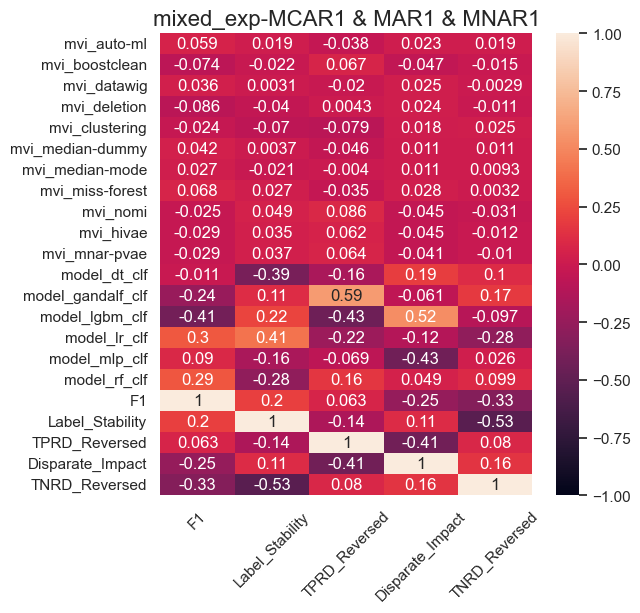

In [86]:
settings_lst = ['Setting_MAR3-MAR3', 'Setting_MAR3-MCAR3', 'Setting_MAR3-MNAR3', 'Setting_MCAR3-MAR3',
                'Setting_MCAR3-MCAR3', 'Setting_MCAR3-MNAR3', 'Setting_MNAR3-MAR3',
                'Setting_mixed_exp-MCAR1 & MAR1 & MNAR1',
                'Setting_MNAR3-MCAR3', 'Setting_MNAR3-MNAR3']

for setting in settings_lst:
    temp = metrics_df_encoded[metrics_df_encoded[setting] == 1]
    temp.rename(columns= col_name_dict, inplace=True)
    target_metrics = ['F1', 'Label_Stability', 'TPRD_Reversed', 'Disparate_Impact', 'TNRD_Reversed']
    # target_metrics = ['Label_Stability', 'Std', 'Aleatoric_Uncertainty', 'Label_Stability_Ratio', 'Std_Ratio', 'Aleatoric_Uncertainty_Ratio']

    get_correlation_matrix_by_target_names(df=temp,
                                           feature_names=list(col_name_dict.values()) + target_metrics,
                                           target_names=target_metrics,
                                           # heatmap_size=(7, 6),
                                           heatmap_size=(6, 6),
                                           xticks_rotation=45,
                                           title=f"{setting}".replace('Setting_mixed_exp', 'mixed_exp'))

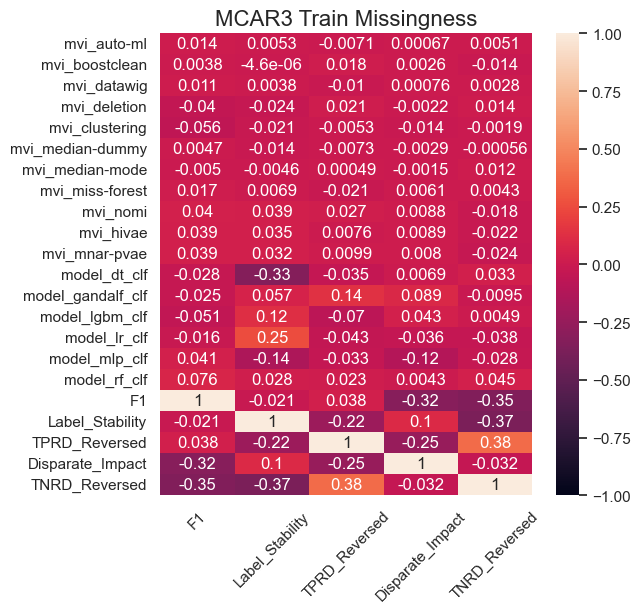

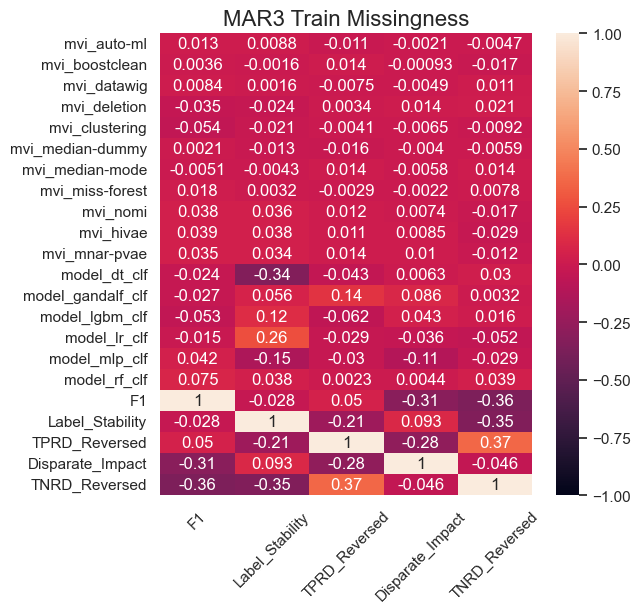

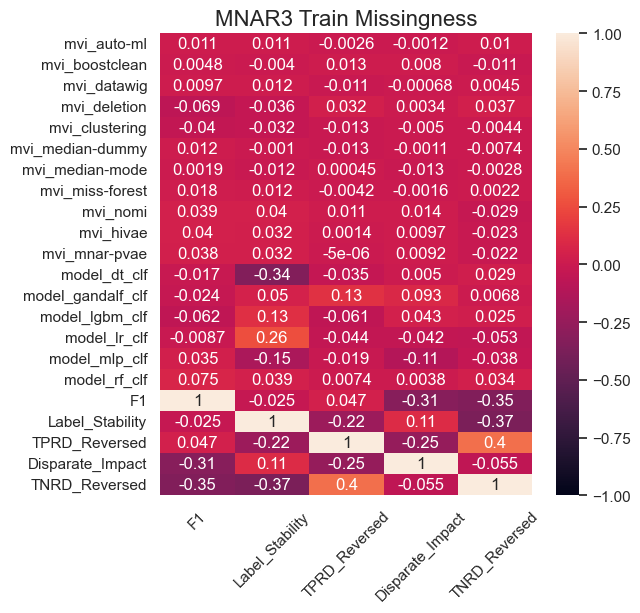

In [84]:
for train__ in ['MCAR3', 'MAR3', 'MNAR3']:
    temp = metrics_df_encoded[metrics_df_encoded.Train_Injection_Scenario == train__]
    temp.rename(columns= col_name_dict, inplace=True)
    # columns_for_correlation_temp = ['Null_Imputer_Name_automl',
    # 'Null_Imputer_Name_boost_clean',
    # 'Null_Imputer_Name_datawig',
    # 'Null_Imputer_Name_deletion',
    # 'Null_Imputer_Name_k_means_clustering',
    # 'Null_Imputer_Name_median-dummy',
    # 'Null_Imputer_Name_median-mode',
    # 'Null_Imputer_Name_miss_forest',
    # 'Model_Name_dt_clf',
    # 'Model_Name_gandalf_clf',
    # 'Model_Name_lgbm_clf',
    # 'Model_Name_lr_clf',
    # 'Model_Name_mlp_clf',
    # 'Model_Name_rf_clf',
    # 'Test_Injection_Scenario_MCAR3', 'Test_Injection_Scenario_MNAR3','Test_Injection_Scenario_MAR3']
    target_metrics = ['F1', 'Label_Stability', 'TPRD_Reversed', 'Disparate_Impact', 'TNRD_Reversed']
    get_correlation_matrix_by_target_names(df=temp,
                                        feature_names=list(col_name_dict.values()) + target_metrics,
                                        target_names=target_metrics,
                                        # heatmap_size=(7, 6),
                                        heatmap_size=(6, 6),
                                        xticks_rotation=45, title=f"{train__} Train Missingness")

In [ ]:
# db_client_1.close()
# db_client_3.close()